In [1]:
# !pip install -U jupyterlab==3.0.16
# !pip install ipywidgets # --user
# !pip install albumentations

In [2]:
import sys
sys.path.append('../../')

In [3]:
# imports
import os
import sys
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from distnet import DistResNeXt50
from dataset import NuScenes
import matplotlib.patches as patches
from albumentations import OneOf, Compose
from albumentations import (HorizontalFlip,
                            HueSaturationValue,
                            RandomBrightnessContrast,
                            Blur,
                            GaussNoise,
                            CLAHE,
                            CoarseDropout,
                            RGBShift,
                            BboxParams)

In [4]:
# set torch random seed
torch.manual_seed(42)

In [5]:
# define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# define an albumentations augmentation routine
alb_aug_list = [HorizontalFlip(p=1),  
                HueSaturationValue(hue_shift_limit=20,
                                   sat_shift_limit=30,
                                   val_shift_limit=20,
                                   p=1),
                RandomBrightnessContrast(brightness_limit=0.2,
                                         contrast_limit=0.2,
                                         brightness_by_max=True,
                                         p=1), 
                Blur(blur_limit=7, #blurring kernel size
                     p=1),
                GaussNoise(var_limit=(10.0, 50.0), #Variance range for noise
                           mean=0,
                           p=1),
                CLAHE(clip_limit=4.0, #Contrast limited adaptive histogram equalization
                      tile_grid_size=(8, 8),
                      p=1),
                RGBShift(p=1)
                ]

train_aug = OneOf(alb_aug_list, p=0.7)

In [7]:
# create a transforms routine
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                              std=[0.229, 0.224, 0.225])
                                            ])

# create training dataset and loader
size = 1024
train_data = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/',
                      meta_path='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/nuscenes-v1.0-mini.csv',
                      augs = train_aug,
                      transforms=transforms,
                      size=size,
                      map_to_kitti=True)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, drop_last=True, shuffle=True, collate_fn=train_data.collate_fn)

/run/determined/workdir/irad_users/fleisig/beholder-ml/notebooks/DistNet/../../dataset.py:85: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = self.metadata.loc[self.sample_list[idx]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


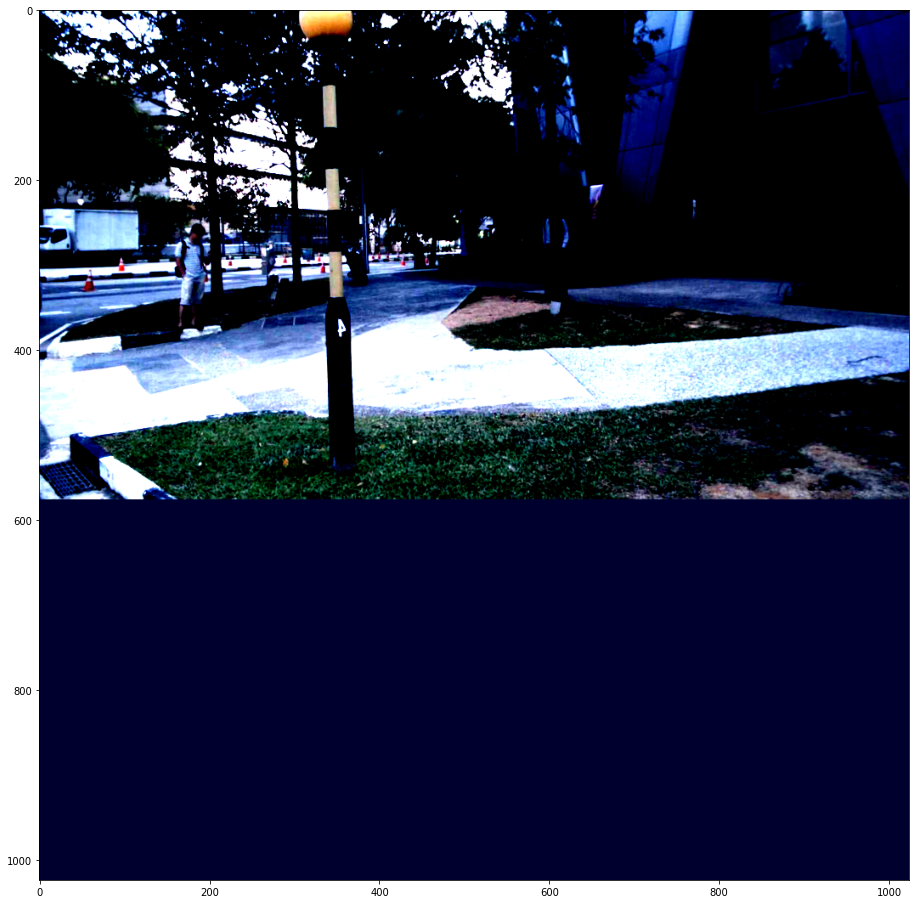

In [8]:
# plot some example training data
idx = 14
image,boxes,distances,classes = train_data.__getitem__(idx)
image,boxes,classes = image.numpy(),boxes.numpy(),classes.numpy()
fig,ax = plt.subplots(figsize=(20,16))
ax.imshow(np.transpose(image, (1,2,0)))
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0],boxes[i][3]),boxes[i][2]-boxes[i][0],boxes[i][1]-boxes[i][3], linewidth=2, edgecolor='r', facecolor='none', label='object')
    ax.add_patch(rect)
plt.show()

In [9]:
# create test dataset and loader
test_data = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/',
                     meta_path='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/nuscenes-v1.0-mini.csv',
                     transforms=transforms, size=size, split='test', map_to_kitti=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=4, drop_last=True, shuffle=False, collate_fn=test_data.collate_fn)

/run/determined/workdir/irad_users/fleisig/beholder-ml/notebooks/DistNet/../../dataset.py:85: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = self.metadata.loc[self.sample_list[idx]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


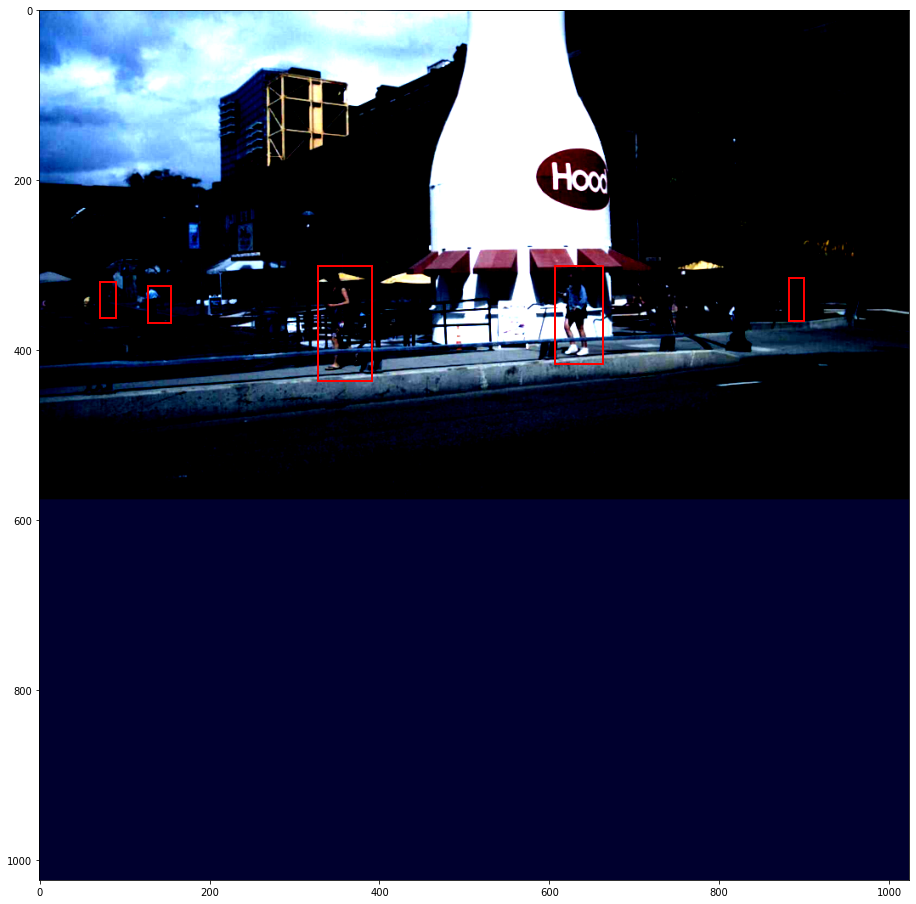

In [10]:
# plot some example test data
idx = 2
image,boxes,distances,classes = test_data.__getitem__(idx)
image,boxes,classes = image.numpy(),boxes.numpy(),classes.numpy()
fig,ax = plt.subplots(figsize=(20,16))
ax.imshow(np.transpose(image, (1,2,0)))
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0],boxes[i][3]),boxes[i][2]-boxes[i][0],boxes[i][1]-boxes[i][3], linewidth=2, edgecolor='r', facecolor='none', label='object')
    ax.add_patch(rect)
plt.show()

In [11]:
# load in our model
model = DistResNeXt50(n_classes=8, image_size=size)
model.to(device)

DistResNeXt50(
  (backbone): ResNeXt50(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [12]:
# define our loss function
class_criterion = torch.nn.CrossEntropyLoss()
dist_criterion = torch.nn.MSELoss()

In [13]:
# define some hyperparameters
n_epochs = 1
lr = 1e-7
weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [14]:
# define our training routine
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    # train loop
    running_train_loss = 0.0

    model.train()
    print('Training...')
    for i,data in enumerate(trainloader, 0):

        # grab the batch and move the batch to the gpu
        inputs,boxes,distances,classes = data[0],data[1],data[2],data[3]
        inputs = inputs.to(device)
        boxes = [b.to(device) for b in boxes]
        distances = torch.cat([d.to(device) for d in distances])
        classes = torch.cat([c.to(device) for c in classes])

        # zero param gradients
        optimizer.zero_grad()
        
        # forward, backward, optimize
        class_preds,distance_preds = model(inputs, boxes)
        loss = class_criterion(class_preds.squeeze(), classes) + 10.0*dist_criterion(distance_preds.squeeze(), distances)
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if (i%100)==0:
            print('batch [{0:}] - loss: {1:.3f}'.format(i,running_train_loss/(i+1)))

    # end of epoch train stats
    train_loss = running_train_loss/(i+1)
    train_losses.append(train_loss)

    # validation loop
    running_val_loss = 0.0

    model.eval()
    print('Performing eval...')
    with torch.no_grad():
        for i,data in enumerate(testloader, 0):
            
            # grab the batch and move the batch to the gpu
            inputs,boxes,distances,classes = data[0],data[1],data[2],data[3]
            inputs = inputs.to(device)
            boxes = [b.to(device) for b in boxes]
            distances = torch.cat([d.to(device) for d in distances])
            classes = torch.cat([c.to(device) for c in classes])

            # forward, backward, optimize
            class_preds,distance_preds = model(inputs, boxes)
            loss = class_criterion(class_preds.squeeze(), classes) + 10.0*dist_criterion(distance_preds.squeeze(), distances)
            running_val_loss += loss.item()

    # calculate final val loss and step scheduler
    val_loss = running_val_loss/(i+1)
    val_losses.append(val_loss)

    # save the model every epoch
    torch.save(model.state_dict(), './distnet_resnext_epoch_{}.pth'.format(epoch))
    
    # print stats
    print('End of epoch stats...')
    print('--------------------------------------------------------------------------------------')
    print('epoch [{0:}] - train_loss: {1:.3f} - val_loss: {2:.3f}'.format(epoch, train_loss, val_loss))
    print('--------------------------------------------------------------------------------------')

Training...
batch [0] - loss: 5.934
batch [100] - loss: 6.292
batch [200] - loss: 6.202
batch [300] - loss: 6.164
batch [400] - loss: 6.105
Performing eval...
End of epoch stats...
--------------------------------------------------------------------------------------
epoch [0] - train_loss: 6.065 - val_loss: 6.110
--------------------------------------------------------------------------------------


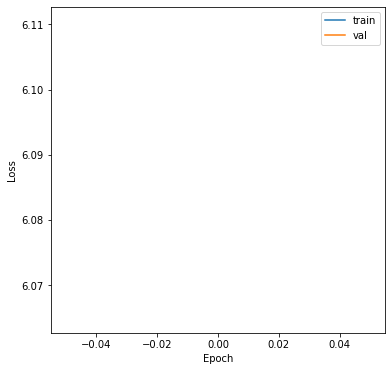

In [15]:
# plot losses
fig,ax = plt.subplots(1, sharex=True, figsize=(6,6))
ax.plot(train_losses)
ax.plot(val_losses)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'])
plt.savefig('losses.png')
plt.show()